In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
predictor_variables = [x for x in train.columns if x not in ['connection_id','target','cat_4','cat_6','cat_17','cat_18',
                                                            'cat_13','cat_14','cat_15','cat_16']]
target = train['target']

In [4]:
def parse_num(x):
    if ((x >= 0.0) & (x <=0.1)):
        return 1
    elif ((x > 0.1) & (x <= 0.2)):
        return 2
    elif ((x > 0.2) & (x <= 0.3)):
        return 3
    elif ((x > 0.3) & (x <= 0.4)):
        return 4
    elif ((x > 0.4) & (x <= 0.5)):
        return 5
    elif ((x > 0.5) & (x <= 0.6)):
        return 6
    elif ((x > 0.6) & (x <= 0.7)):
        return 7
    elif ((x > 0.7) & (x <= 0.8)):
        return 8
    elif ((x > 0.8) & (x <= 0.9)):
        return 9
    elif (x > 0.9):
        return 10

In [5]:
cols_to_be_parsed = train.columns[4:19].tolist()

for cols in cols_to_be_parsed:
    train[cols] = train[cols].apply(parse_num)

In [25]:
train.head()

,connection_id,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,...,cat_15,cat_16,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,target
0,cxcon_1,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,2
1,cxcon_4,0,520,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,0
2,cxcon_7,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,0
3,cxcon_10,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,0
4,cxcon_13,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,2


In [4]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'], eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-mlogloss:1.02487+4.61519e-05	test-mlogloss:1.02493+5.61733e-05
[1]	train-mlogloss:0.962626+0.000204912	test-mlogloss:0.962749+0.000268271
[2]	train-mlogloss:0.909647+0.000158099	test-mlogloss:0.909832+0.000326024
[3]	train-mlogloss:0.863994+0.000208379	test-mlogloss:0.86424+0.000436603
[4]	train-mlogloss:0.824397+0.000255713	test-mlogloss:0.82472+0.000418796
[5]	train-mlogloss:0.789959+0.000342193	test-mlogloss:0.79035+0.000531904
[6]	train-mlogloss:0.759873+0.000580535	test-mlogloss:0.760322+0.000707693
[7]	train-mlogloss:0.733086+0.000493943	test-mlogloss:0.733577+0.000692469
[8]	train-mlogloss:0.709316+0.000432567	test-mlogloss:0.709843+0.000761452
[9]	train-mlogloss:0.688414+0.000431652	test-mlogloss:0.688989+0.000810173

Model Report
Accuracy : 0.7781


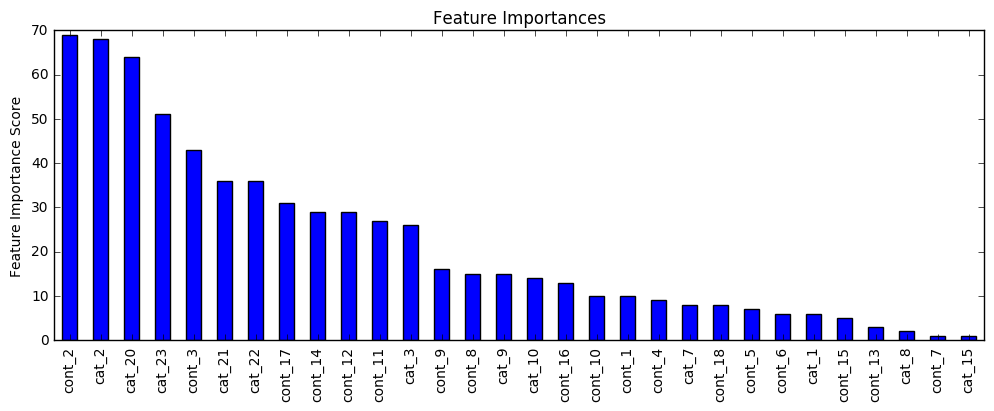

In [18]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=10,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=3,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb1, train, predictor_variables)

[0]	train-mlogloss:1.02487+4.61519e-05	test-mlogloss:1.02493+5.61733e-05
[1]	train-mlogloss:0.962626+0.000204912	test-mlogloss:0.962749+0.000268271
[2]	train-mlogloss:0.909647+0.000158099	test-mlogloss:0.909832+0.000326024
[3]	train-mlogloss:0.863994+0.000208379	test-mlogloss:0.86424+0.000436603
[4]	train-mlogloss:0.824397+0.000255713	test-mlogloss:0.82472+0.000418796
[5]	train-mlogloss:0.789959+0.000342193	test-mlogloss:0.79035+0.000531904
[6]	train-mlogloss:0.759873+0.000580535	test-mlogloss:0.760322+0.000707693
[7]	train-mlogloss:0.733086+0.000493943	test-mlogloss:0.733577+0.000692469
[8]	train-mlogloss:0.709316+0.000432567	test-mlogloss:0.709843+0.000761452
[9]	train-mlogloss:0.688414+0.000431652	test-mlogloss:0.688989+0.000810173
[10]	train-mlogloss:0.669786+0.000505358	test-mlogloss:0.670412+0.000790204
[11]	train-mlogloss:0.65318+0.000545993	test-mlogloss:0.653863+0.000921338
[12]	train-mlogloss:0.638168+0.000428411	test-mlogloss:0.638886+0.000919873
[13]	train-mlogloss:0.624693

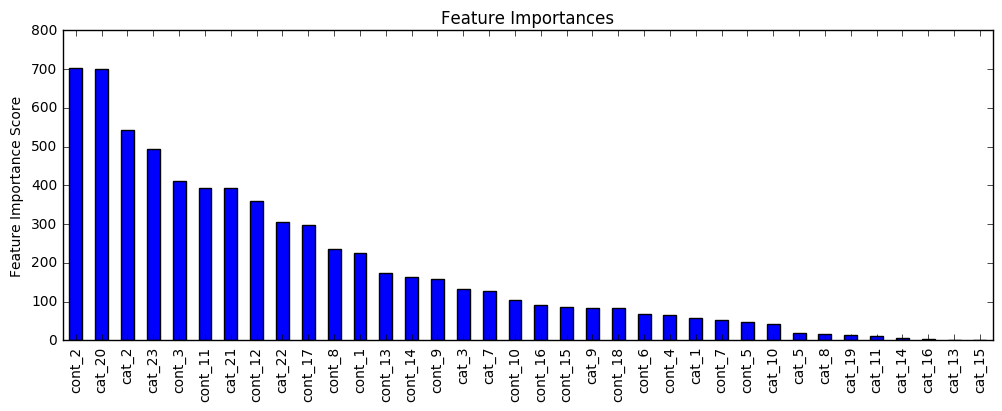

In [19]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=3,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb2, train, predictor_variables)

[0]	train-mlogloss:1.02463+0.000169636	test-mlogloss:1.02468+0.000204862
[1]	train-mlogloss:0.962379+0.000260962	test-mlogloss:0.962471+0.000304569
[2]	train-mlogloss:0.909167+0.000476841	test-mlogloss:0.909323+0.000484115
[3]	train-mlogloss:0.863507+0.000394006	test-mlogloss:0.863717+0.000377197
[4]	train-mlogloss:0.823927+0.000430196	test-mlogloss:0.824187+0.000375797
[5]	train-mlogloss:0.789386+0.000404609	test-mlogloss:0.789708+0.000482303
[6]	train-mlogloss:0.759191+0.000404625	test-mlogloss:0.759583+0.000551249
[7]	train-mlogloss:0.732542+0.00050886	test-mlogloss:0.732978+0.000580221
[8]	train-mlogloss:0.708949+0.000460977	test-mlogloss:0.70943+0.000593895
[9]	train-mlogloss:0.688102+0.000384639	test-mlogloss:0.688638+0.000649823
[10]	train-mlogloss:0.669538+0.000281707	test-mlogloss:0.670132+0.000729121
[11]	train-mlogloss:0.652911+0.00041145	test-mlogloss:0.65356+0.000707951
[12]	train-mlogloss:0.637944+0.000335799	test-mlogloss:0.638653+0.000736388
[13]	train-mlogloss:0.624571

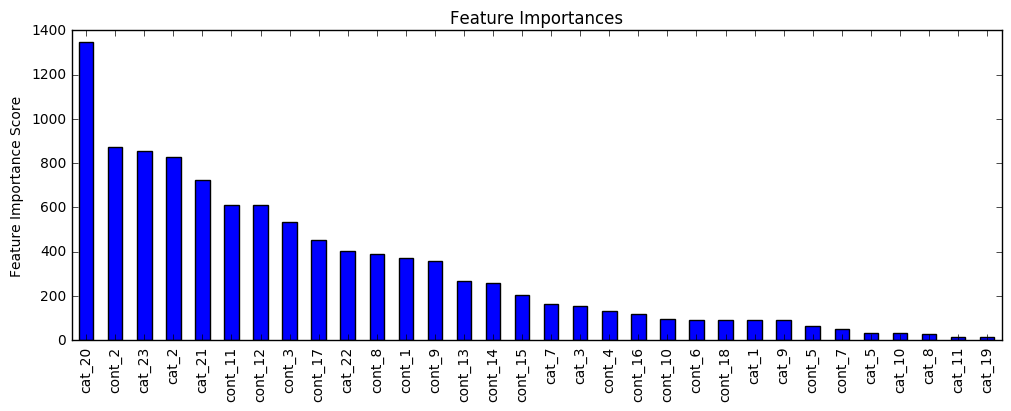

In [28]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=3,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb3, train, predictor_variables)

In [32]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=3,
 scale_pos_weight=1,
 random_state=27)

In [30]:
xgb3.fit(train[predictor_variables], train['target'], eval_metric='mlogloss')
        
#Predict training set:
pred4 = xgb3.predict(test[predictor_variables])

In [31]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred4
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub4.csv', index=False)

In [ ]:
param_test = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        num_class=3,
        scale_pos_weight=1,
        random_state=27
    ), param_grid=param_test, scoring='accuracy', cv=5)

gsearch.fit(train[predictor_variables], train['target'])
print gsearch.best_params_
print gsearch.best_score_

In [ ]:
param_test2 = {
    'max_depth': range(5,11)
}

gsearch2 = GridSearchCV(estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        num_class=3,
        scale_pos_weight=1,
        random_state=27
    ), param_grid=param_test2, scoring='accuracy', cv=5)

gsearch2.fit(train[predictor_variables], train['target'])
print gsearch2.best_params_
print gsearch2.best_score_